In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy

In [2]:
class Rectangle:
    
    def __init__(self, width, height, value, x_left, y_down):
        self.width = width
        self.height = height
        self.value = value
        self.x_left = x_left
        self.y_down = y_down
        x_right = x_left + width
        y_top = y_down + height
        self.vertices = [[x_left, y_down], [x_right, y_down],
                        [x_right, y_top], [x_left, y_top]]
        
    def move(self, move_right=0, move_up=0):
        self.x_left += move_right
        self.y_down += move_up
        x_right = self.x_left + self.width
        y_top = self.y_down + self.height
        self.vertices = [[self.x_left, self.y_down], [x_right, self.y_down],
                        [x_right, y_top], [self.x_left, y_top]]
        
    def rotate(self):
        self.width, self.height = self.height, self.width
        self.vertices = [[self.x_left, self.y_down],
                         [self.x_left + self.width, self.y_down],
                         [self.x_left + self.width, self.y_down + self.height],
                         [self.x_left, self.y_down + self.height]]
    
        
    def is_intersection(self, rectangle2):
                
        R1 = [self.x_left, self.y_down, self.x_left + self.width, self.y_down + self.height]
        R2 = [rectangle2.x_left, rectangle2.y_down,
              rectangle2.x_left + rectangle2.width, rectangle2.y_down + rectangle2.height]
        
        if R1[0] >= R2[2] or R1[2] <= R2[0] or R1[3] <= R2[1] or R1[1] >= R2[3]:
            return False
        
        return True
    
    def is_in_circle(self, radius):
        for vertex in self.vertices:
            if vertex[0] ** 2 + vertex[1] ** 2 > radius ** 2:
                return False
        return True

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as Rectangle2
from matplotlib.patches import Circle as Circle2

class Circle:
    def __init__(self, radius, rectangles=[]):
        self.radius = radius
        self.rectangles = deepcopy(rectangles)
    
    def initialize(self, possible_rectangles, rotate_proba=0):
          
        while True:
            r_to_copy = deepcopy(random.choice(possible_rectangles))
            if np.random.uniform(low=0, high=1, size=1) < rotate_proba:
                r_to_copy.rotate()

            flag2 = False
            for i in range(1000):
                r = deepcopy(r_to_copy)
                if i == 999:
                    flag2 = True
                move_right = random.uniform(-self.radius, self.radius)
                move_up = random.uniform(-self.radius, self.radius)
                r.move(move_right, move_up)
                if not r.is_in_circle(self.radius):
                    continue
                flag = False
                for r2 in self.rectangles:
                    if r.is_intersection(r2):
                        flag = True
                        break
                if flag:
                    continue
                self.rectangles.append(r)
                break
            if flag2:
                break
                
    def plot_solution(self):
        
        fig, ax = plt.subplots()

        fig.set_size_inches(8, 8)
        ax.set_xlim(left=-self.radius-5, right=self.radius+5)
        ax.set_ylim(bottom=-self.radius-5, top=self.radius+5)
        
        ax.add_patch(Circle2((0, 0), radius=self.radius, fill=False))
        
        for r in self.rectangles:
            ax.add_patch(Rectangle2((r.x_left, r.y_down), r.width, r.height, edgecolor='black'))

        plt.show()
        
    def fitness_score(self):
        result = 0
        for rectangle in self.rectangles:
            result += rectangle.value
        return result

In [4]:
class Population:
    
    def __init__(self, possible_rectangles=[], radius=None, circles=[]):
        self.circles = circles
        self.possible_rectangles = possible_rectangles
        self.num_of_specimens = len(circles)
        self.radius = radius
        
    def initialize_circles(self, num_of_specimens):
        for rectangle in self.possible_rectangles:
            C = Circle(self.radius)
            C.initialize([rectangle], rotate_proba=0.5)
            self.circles.append(deepcopy(C))
        for _ in range(len(self.circles), num_of_specimens):
            C = Circle(self.radius)
            C.initialize(self.possible_rectangles, rotate_proba=0.5)
            self.circles.append(deepcopy(C))
        self.num_of_specimens = len(self.circles)
        
        
    def cross(self, proba=0.7):
        def __cross(circle1, circle2):
            rectangles_crossed = []
            rectangles_1 = deepcopy(circle1.rectangles)
            rectangles_2 = deepcopy(circle2.rectangles)
            for i in range(min(len(rectangles_1), len(rectangles_2))):
                rectangle1 = rectangles_1[i]
                flag_r1_it = False
                for rectangle in rectangles_crossed:
                    if rectangle1.is_intersection(rectangle):
                        flag_r1_it = True
                        break
                if not flag_r1_it:
                    rectangles_crossed.append(deepcopy(rectangle1))

                rectangle2 = rectangles_2[i]
                flag_r2_it = False
                for rectangle in rectangles_crossed:
                    if rectangle2.is_intersection(rectangle):
                        flag_r2_it = True
                        break
                if not flag_r2_it:
                    rectangles_crossed.append(deepcopy(rectangle2))

            if len(rectangles_1) < len(rectangles_2):
                for i in range(len(rectangles_1), len(rectangles_2)):
                    rectangle2 = rectangles_2[i]
                    flag_r2_it = False
                    for rectangle in rectangles_crossed:
                        if rectangle2.is_intersection(rectangle):
                            flag_r2_it = True
                            break
                    if not flag_r2_it:
                        rectangles_crossed.append(deepcopy(rectangle2))

            else:
                for i in range(len(rectangles_2), len(rectangles_1)):
                    rectangle1 = rectangles_1[i]
                    flag_r1_it = False
                    for rectangle in rectangles_crossed:
                        if rectangle1.is_intersection(rectangle):
                            flag_r1_it = True
                            break
                    if not flag_r1_it:
                        rectangles_crossed.append(deepcopy(rectangle1))


            return Circle(radius=circle1.radius, rectangles=rectangles_crossed)     
        
        circles = deepcopy(self.circles)
        random.shuffle(circles)
        new_results = []
        
        for i in range(0, len(circles)-1):
            if np.random.uniform(low=0, high=1, size=1) > proba:
                continue
                
            new_circle = __cross(circles[i], circles[i+1])
            new_results.append(new_circle)
        
        circles += new_results
        
        return circles
    
    
    def mutate(self, proba=0.7):

        def __move_left_down(rectangle, other_rectangles, radius, move_left=False, move_down=False):
            if move_left:
                delta_x = radius / 1000
            else: 
                delta_x = 0

            if move_down:
                delta_y = radius / 1000
            else:
                delta_y = 0

            r = deepcopy(rectangle)

            while True:
                r.move(move_right=-delta_x, move_up=-delta_y)

                if not r.is_in_circle(radius):
                    r.move(move_right=delta_x, move_up=delta_y)
                    break

                flag_is_int = False
                for rectangle2 in other_rectangles:
                    if r.is_intersection(rectangle2):
                        flag_is_int = True
                        r.move(move_right=delta_x, move_up=delta_y)
                        break

                if flag_is_int:
                    break

            return r
        
        def __rotate(rectangle, other_rectangles, radius):
            
            r = deepcopy(rectangle)
            r.rotate()
            
            if not r.is_in_circle(radius):
                return rectangle
            
            for rectangle2 in other_rectangles:
                if r.is_intersection(rectangle2):
                    return rectangle
            
            return r
        
        def __add_rectangle(possible_rectangle, radius, all_rectangles, rotate_proba=0.5):
            
            r_to_copy = deepcopy(possible_rectangle)
            
            if np.random.uniform(low=0, high=1, size=1) < rotate_proba:
                r_to_copy.rotate()
                
            flag_add = False
            for i in range(1000):
                
                r = deepcopy(r_to_copy)
                    
                move_right = random.uniform(-radius, radius)
                move_up = random.uniform(-radius, radius)
                r.move(move_right, move_up)
                
                if not r.is_in_circle(radius):
                    continue
                    
                flag = False
                for r2 in all_rectangles:
                    if r.is_intersection(r2):
                        flag = True
                        break
                if flag:
                    continue
                
                return r
            
            return None
        
        for i, circle in enumerate(self.circles):
            
            if np.random.uniform(low=0, high=1, size=1) > proba:
                continue
                
        # move left and down 
            r_idx = random.randint(0, len(circle.rectangles) - 1)
            new_r = deepcopy(circle.rectangles[r_idx])
            other_rectangles = circle.rectangles[:r_idx] + circle.rectangles[r_idx+1:]
            while True:
                new_r = __move_left_down(new_r, other_rectangles,
                                         circle.radius, move_left=True, move_down=False)
                new_r = __move_left_down(new_r, other_rectangles,
                                         circle.radius, move_left=False, move_down=True)
                
                self.circles[i].rectangles[r_idx] = deepcopy(new_r)
                war1 = abs(self.circles[i].rectangles[r_idx].x_left - new_r.x_left) < 0.00001
                war2 = abs(self.circles[i].rectangles[r_idx].y_down - new_r.y_down) < 0.00001
                #print(war1, war2)
                if (war1 and war2):
                    break
            
            # rotate
            
            r_idx = random.randint(0, len(circle.rectangles) - 1)
            rectangle = deepcopy(circle.rectangles[r_idx])
            other_rectangles = circle.rectangles[:r_idx] + circle.rectangles[r_idx+1:]
            new_r = __rotate(rectangle, other_rectangles, circle.radius)
            self.circles[i].rectangles[r_idx] = deepcopy(new_r)
            
            # add new rectangle
            
            possible_rectangle = deepcopy(random.choice(possible_rectangles))
            new_r = __add_rectangle(possible_rectangle, circle.radius, circle.rectangles)
            if new_r is not None:
                self.circles[i].rectangles.append(deepcopy(new_r))
                
                
    def selection(self):
        
        circles = deepcopy(self.circles)
        circles += deepcopy(self.cross())
        
        scores = []
        
        for i, circle in enumerate(circles):
            scores.append(circle.fitness_score())
            
        df = pd.DataFrame({'scores': scores})
        df = df.sort_values(by='scores', ascending=False)
        indices = list(df.index)

        n = self.num_of_specimens

        circles = np.array(circles)

        new_circles = np.array([])
        new_circles = np.append(new_circles, circles[indices[:int(0.02*n)]])

        new_indices = random.sample(indices[int(0.02*n):int(0.2*n)], int(0.18*n*0.9))
        new_circles = np.append(new_circles, circles[new_indices])

        new_indices = random.sample(indices[int(0.2*n):int(0.6*n)], int(0.4*n*0.85))
        new_circles = np.append(new_circles, circles[new_indices])

        new_indices = random.sample(indices[int(0.6*n):int(n)], int(0.4*n*0.75))
        new_circles = np.append(new_circles, circles[new_indices])

        new_indices = random.sample(indices[int(n):], n-len(new_circles))
        new_circles = np.append(new_circles, circles[new_indices])
        
        return list(new_circles)
    
    def epoch(self):
        
        self.mutate()
        self.circles = deepcopy(self.selection())
        
        
    def run(self, num_of_epochs):
        for i in range(num_of_epochs):
            print(f'{i+1} / {num_of_epochs}')
            self.epoch()
    
        
    def circle_with_max_score(self):
        
        scores = []
        circles = deepcopy(self.circles)
        
        for i, circle in enumerate(circles):
            scores.append(circle.fitness_score())
            
        df = pd.DataFrame({'scores': scores})
        df = df.sort_values(by='scores', ascending=False)
        indices = list(df.index)
        
        return deepcopy(circles[indices[0]])

# R800

In [ ]:
r800 = pd.read_csv('cutting/r800.csv', header=None)

In [ ]:
possible_rectangles = []

for i in range(r800.size//3):
    w = r800[0][i]
    h = r800[1][i]
    v = r800[2][i]
    possible_rectangles.append(Rectangle(w, h, v, 0, 0))

In [ ]:
for r in possible_rectangles:
    print(r.value)

In [ ]:
P = Population(possible_rectangles, radius=800)
P.initialize_circles(50)
P.run(30)
C = P.circle_with_max_score()
C.plot_solution()

In [ ]:
C.fitness_score()

# R850

In [ ]:
r850 = pd.read_csv('cutting/r850.csv', header=None)

In [ ]:
possible_rectangles = []

for i in range(r850.size//3):
    w = r850[0][i]
    h = r850[1][i]
    v = r850[2][i]
    possible_rectangles.append(Rectangle(w, h, v, 0, 0))

In [ ]:
P2 = Population(possible_rectangles, radius=850)
P2.initialize_circles(30)
P2.run(50)
C2 = P2.circle_with_max_score()
C2.plot_solution()

In [ ]:
C2.fitness_score()

# R1000

In [ ]:
r1000 = pd.read_csv('cutting/r1000.csv', header=None)

In [ ]:
possible_rectangles = []

for i in range(r1000.size//3):
    w = r1000[0][i]
    h = r1000[1][i]
    v = r1000[2][i]
    possible_rectangles.append(Rectangle(w, h, v, 0, 0))

In [ ]:
P3 = Population(possible_rectangles, radius=1000)
P3.initialize_circles(30)
P3.run(100)
C3 = P3.circle_with_max_score()
C3.plot_solution()

In [ ]:
C3.fitness_score()

# R1100

In [ ]:
r1100 = pd.read_csv('cutting/r1100.csv', header=None)

In [ ]:
possible_rectangles = []

for i in range(r1100.size//3):
    w = r1100[0][i]
    h = r1100[1][i]
    v = r1100[2][i]
    possible_rectangles.append(Rectangle(w, h, v, 0, 0))

In [ ]:
for r in possible_rectangles:
    print(r.width, r.height, r.value, r.width*r.height, r.width*r.height/r.value)

In [ ]:
P4 = Population(possible_rectangles, radius=1100)
P4.initialize_circles(30)
P4.run(25)
C4 = P4.circle_with_max_score()
C4.plot_solution()

In [ ]:
C4.fitness_score()

# R1200

In [5]:
r1200 = pd.read_csv('cutting/r1200.csv', header=None)

In [6]:
possible_rectangles = []

for i in range(r1200.size//3):
    w = r1200[0][i]
    h = r1200[1][i]
    v = r1200[2][i]
    possible_rectangles.append(Rectangle(w, h, v, 0, 0))

In [9]:
for r in possible_rectangles:
    print(r.value)

200
300
500
40


1 / 20
2 / 20
3 / 20
4 / 20
5 / 20
6 / 20
7 / 20
8 / 20
9 / 20
10 / 20
11 / 20
12 / 20
13 / 20
14 / 20
15 / 20
16 / 20
17 / 20
18 / 20
19 / 20
20 / 20


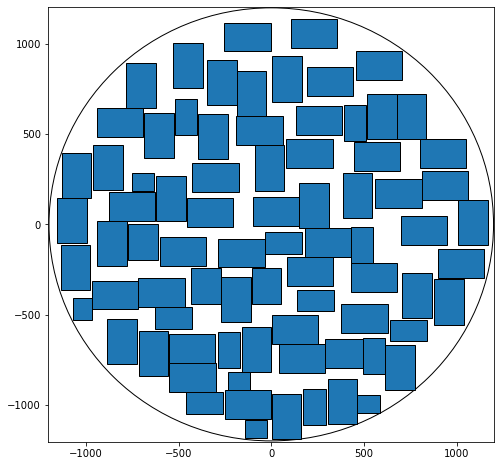

In [7]:
P5 = Population(possible_rectangles, radius=1200)
P5.initialize_circles(30)
P5.run(20)
C5 = P5.circle_with_max_score()
C5.plot_solution()

In [8]:
C5.fitness_score()

33100